/kaggle/input/epl-dataset-20222023-update-every-week/player_info.csv
/kaggle/input/epl-dataset-20222023-update-every-week/epl_2022_2023_07_02_2023.json


,Home Game Shoots,Away Game Shoots,Total Shoots
Team Name,,,
Fulham,172,143,315
Wolverhampton Wanderers,144,165,309
Manchester City,201,89,290
Tottenham Hotspur,148,138,286
Crystal Palace,141,144,285
Newcastle United,192,92,284
Manchester United,162,119,281
Brentford,124,152,276
Leeds United,132,140,272


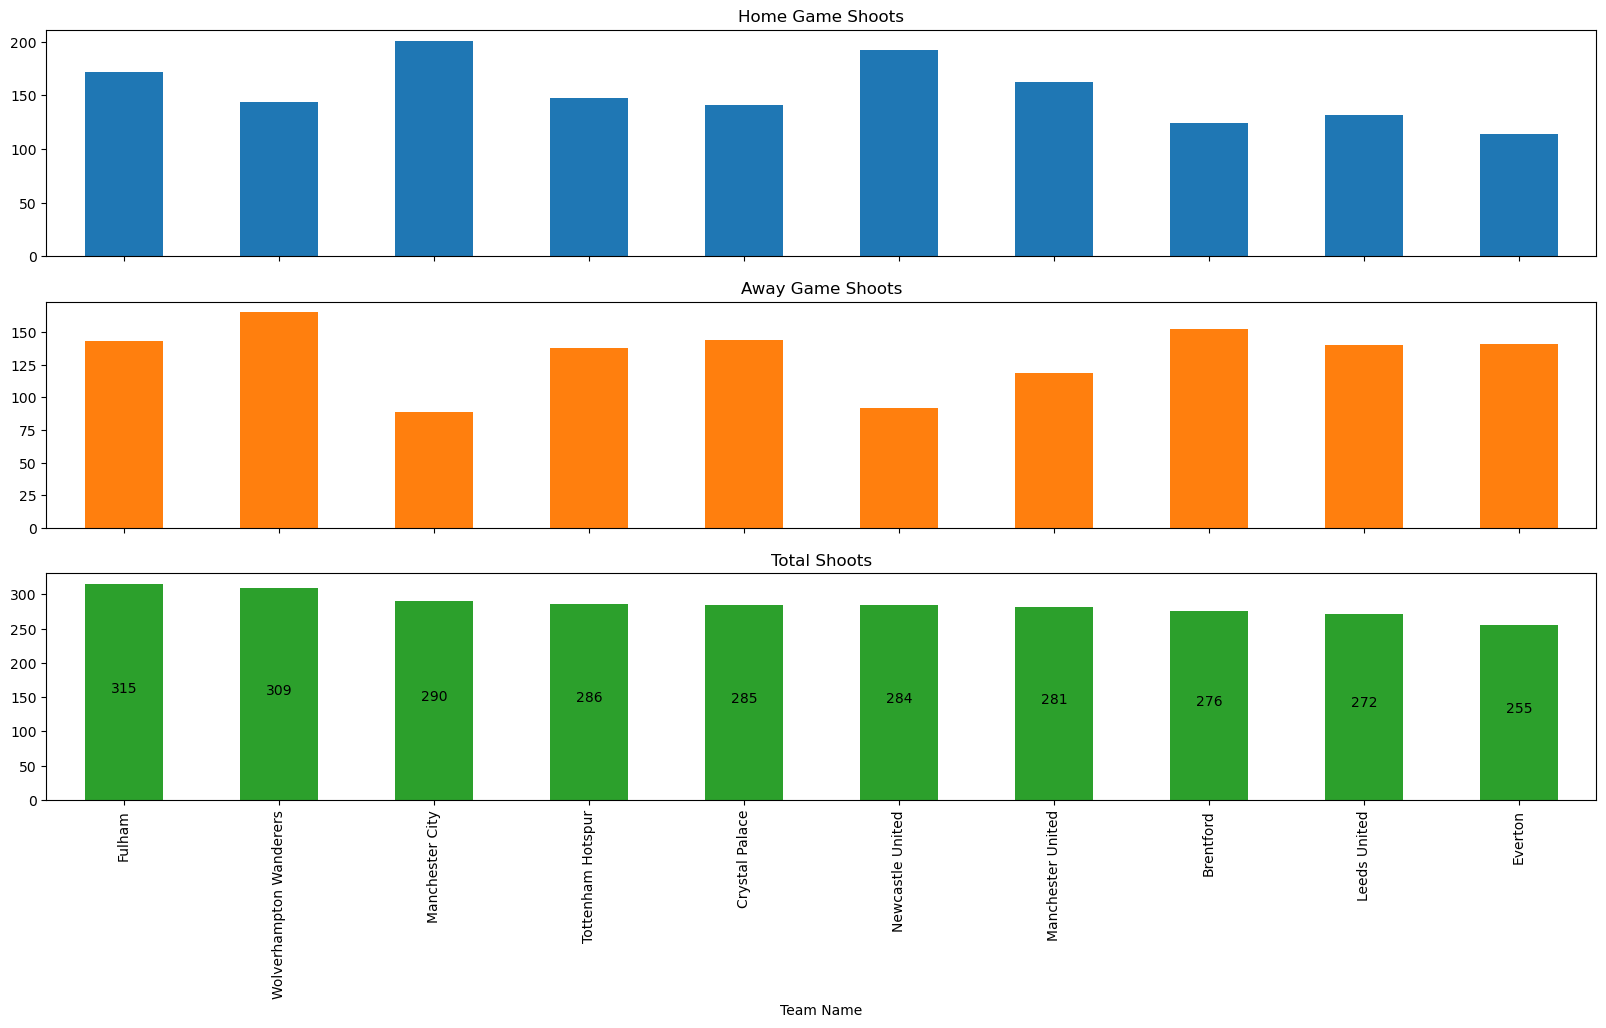

In [1]:
import numpy as np # linear algebra
import warnings
from IPython.display import IFrame
import csv
import random
import matplotlib.pyplot as plt
import base64
from collections import defaultdict
import matplotlib.pyplot as plt
import requests
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import math
from collections import defaultdict
import pprint
import re
import fnmatch
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# Target of this work is to create as much as analytics from a semi-structured JSON format dataset and CSV formatted second dataset
# Initial target is to use pandas and numpy methods on analysis


with open("../input/epl-dataset-20222023-update-every-week/epl_2022_2023_07_02_2023.json", 'r',encoding="UTF-8") as my_file:
    data = my_file.read().replace('&','and')
    obj = json.loads(data)

#Creating Gameid list from dataset
Game_ids = []
for key, value in obj.items(): 
    Game_ids.append(key)
         

#Normalized JSON data and created structured dataset
Normalized = pd.concat([pd.json_normalize(obj[str(i)]) for i in Game_ids])
Normalized

warnings.filterwarnings('ignore') # Hide Warnings

#Dimensions of the Dataset
Normalized.shape

#Team column addition for further join operation
Normalized['team'] = Normalized['team1_name']


#Cleaning non-numeric value holding rows to get clean dataset from columns 'team1_stat.possession_%' & 'team2_stat.possession_%' and creating a new df Normalized_2 dataframe on it 
Normalized['team1_stat.possession_%'] = pd.to_numeric(Normalized['team1_stat.possession_%'], errors='coerce')
Normalized_2 = Normalized.dropna(subset=['team1_stat.possession_%'])
Normalized['team2_stat.possession_%'] = pd.to_numeric(Normalized['team2_stat.possession_%'], errors='coerce')
Normalized_2 = Normalized.dropna(subset=['team2_stat.possession_%'])

#Checking first 5 rows
Normalized_2.head()

#Converting non-numeric columns to numeric data types for analytical purposes
Normalized_2.loc[:,'team1_stat.possession_%':] = Normalized_2.loc[:,'team1_stat.possession_%':].apply(pd.to_numeric, errors = 'coerce')

#Checking datatypes
Normalized_2.dtypes


#Top 10 Most Shoot MadeTeam

Normalized_2.loc[Normalized_2['team1_stat.shots']> 100, 'team1_stat.shots'] = 20  ## There are outlier values on shot stats assigning 20 instead of excessive outliers

Normalized_2.loc[Normalized_2['team2_stat.shots']> 100, 'team2_stat.shots'] = 20  ## There are outlier values on shot stats assigning 20 instead of excessive outliers

Normalized_2["Total_Shoots"] = Normalized_2.loc[:,['team1_stat.shots','team2_stat.shots']].sum(axis=1)

Normalized_2['Team Name'] = Normalized_2['team1_name']

Normalized_2 = Normalized_2.groupby(['Team Name']).sum()

Normalized_2['Shoot_rank'] = Normalized_2['Total_Shoots'].rank(ascending=False)

Normalized_2 = Normalized_2.sort_values(by='Shoot_rank', ascending=True)

Top_10_shooter_teams = Normalized_2[['team1_stat.shots','team2_stat.shots','Total_Shoots','Shoot_rank']]

Top_10_shooter_teams = Top_10_shooter_teams.rename(columns={"team1_stat.shots": "Home Game Shoots", "team2_stat.shots": "Away Game Shoots",'Total_Shoots': 'Total Shoots', 'Shoot_rank' : 'Total Shoot Rank' })

#Top_10_shooter_teams = Top_10_shooter_teams.Index.set_names("Team Name", inplace = True) ##Index name setter

Top_10_shooter_teams = Top_10_shooter_teams.head(10)

Top_10_shooter_teams.head(1) # TOP 1 team of all dataset

Top_10_shooter_teams = Top_10_shooter_teams.loc[:,['Home Game Shoots','Away Game Shoots','Total Shoots']]


#Barchart creation for Top_10_shooter_teams dataframe

ax = Top_10_shooter_teams.plot.bar(subplots=True,legend=False,figsize=(20,10))

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
        
        
addlabels(Top_10_shooter_teams['Total Shoots'], Top_10_shooter_teams['Total Shoots'])


#Getting data from Players list in csv format to create merged data with key (player name as FK)

players = pd.read_csv("../input/epl-dataset-20222023-update-every-week/player_info.csv")


#Detecting differences of team names between players dataset and normalized datasets

unique_team_names = players['team'].unique() 

unique_team_names_ = pd.DataFrame(unique_team_names, columns = ['team'])

unique_team_names_2 = Normalized['team1_name'].unique()

unique_team_names_2_ = pd.DataFrame(unique_team_names_2, columns = ['team'])

df_diff = pd.concat([unique_team_names_,unique_team_names_2_]).drop_duplicates(keep=False)


#Matching/equaling team names between players and normalized datasets with replacing/converting unwanted team names on players table (differences detected on previous step)

players = players.replace(to_replace=r"\ FC$", value='', regex=True).replace(to_replace=r"AFC ", value='', regex=True).replace(to_replace=r" & ", value=' and ', regex=True)


#Merging 2 dataframes and creating Normalized_3 dataframe

Normalized_3 = pd.merge(players,Normalized,how = "left", on = ['team'])


#Data type change and clean outlier values on newly created Normalized_3 dataframe

Normalized_3.loc[:,'team1_stat.possession_%':] = Normalized_3.loc[:,'team1_stat.possession_%':].apply(pd.to_numeric, errors = 'coerce')

Normalized_3.loc[Normalized_3['team1_stat.shots']> 100, 'team1_stat.shots'] = 20  ## There are outlier values on shot stats assigning 20 instead of excessive outliers

Normalized_3.loc[Normalized_3['team2_stat.shots']> 100, 'team2_stat.shots'] = 20  ## There are outlier values on shot stats assigning 20 instead of excessive outliers


#Finding stats about players starting line up staus over whole league

Normalized_3['player_name'].nunique() #unique player count

unique_players = Normalized_3['player_name'].drop_duplicates() #Unique player series

c = pd.concat([Normalized['team1_startings'],Normalized['team2_startings']]) #concat 2 series for starting eleven players on home and on away

d = c.explode() #got all series elements in a single series

d.value_counts(sort=True) # which player started how many times

d.nunique() # How many unique players started on started lineups

start_percent = d.nunique()/unique_players.count() #Starting lineup percentage of all league players

start_percentage = "{:.2%}".format(start_percent) #Starting lineup percentage of all league players


# Starting lineup player count second method with merge/join of 2 dataframes

data_frame_d = pd.DataFrame(data = d,columns = ['player_name']).drop_duplicates()

data_frame_unique = pd.DataFrame(data = unique_players,columns = ['player_name'])

started_players = pd.merge(data_frame_d,data_frame_unique,how = "left", on = ['player_name']) ## result is 440 same- with d.nunique()

#print("List of starting lineuped players at least 1 time:", started_players)

Top_10_shooter_teams



In [2]:
print("Started Lineup Players Percentage over All Player Count:", start_percentage)

print("Top 10 Most starting lineuped players:")

d.value_counts(sort=True).head(10)

Started Lineup Players Percentage over All Player Count: 66.87%
Top 10 Most starting lineuped players:


Harry Kane               22
Andreas Pereira          22
Tim Ream                 22
Maximilian Kilman        21
Alex Iwobi               21
Bobby De Cordova-Reid    21
José Sá                  21
João Palhinha            21
Ederson                  21
Mathias Jensen           21
dtype: int64